## 1. the following steps need to be carried out when running on colabWhen running on colab

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
##https://drive.google.com/file/d/1xP1nXhrI1ZkAC2uezIMYf5-PUUOYYaGQ/view?usp=sharing
your_file = drive.CreateFile({'id':'1xP1nXhrI1ZkAC2uezIMYf5-PUUOYYaGQ'})

In [4]:
your_file.GetContentFile('bitcoin-ta-2015.csv')

## 2. Carry out bayesian optimisation. Optimising: batch_size, dropout, epochs, learning_rate, units

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

# Read dataset
df = pd.read_csv('bitcoin-ta-2015.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

def create_model(params):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=int(params['units']), return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(params['dropout']))
    model.add(Bidirectional(LSTM(units=int(params['units']), return_sequences=False)))
    model.add(Dense(25))
    model.add(Dense(1))
    return model

def objective(params):
    model = create_model(params)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mean_squared_error')

    # Train the model
    model.fit(params['X_train'], params['y_train'], epochs=int(params['epochs']), batch_size=int(params['batch_size']), validation_split=0.2, verbose=0)


    # Validation
    test_data = scaler.transform(params['test'])
    X_test = []
    y_test = []  # Initialize y_test as empty list

    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i, :])  # Appending X_test
        y_test.append(params['test'].iloc[i]['Close'])  # Append corresponding y_test

    y_test = np.array(y_test)  # Convert y_test to numpy array


    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    # Check the model's prediction
    predictions = model.predict(X_test)

    price_scaler = MinMaxScaler(feature_range=(0,1))
    price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

    # Now you can inverse_transform your predictions
    predictions = price_scaler.inverse_transform(predictions)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, predictions)

    return {'loss': mse, 'status': STATUS_OK}

# Hyperparameters space
space = {
    'units': hp.quniform('units', 50, 200, 1),
    'dropout': hp.uniform('dropout', 0.0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'epochs': hp.quniform('epochs', 20, 50, 5),
    'batch_size': hp.quniform('batch_size', 10, 100, 1),
    'X_train': X_train,
    'y_train': y_train,
    'test': test
}

# Trials object to store the optimization history
trials = Trials()

# Run the algorithm
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

2416 604
17/17 [==============================] - 1s 9ms/step

17/17 [==============================] - 3s 12ms/step

17/17 [==============================] - 1s 8ms/step

17/17 [==============================] - 1s 9ms/step

17/17 [==============================] - 2s 12ms/step

17/17 [==============================] - 1s 8ms/step

17/17 [==============================] - 1s 8ms/step

17/17 [==============================] - 1s 9ms/step

17/17 [==============================] - 1s 10ms/step

17/17 [==============================] - 1s 9ms/step

17/17 [==============================] - 1s 10ms/step

17/17 [==============================] - 1s 8ms/step

17/17 [==============================] - 1s 8ms/step

17/17 [==============================] - 1s 8ms/step

17/17 [==============================] - 2s 11ms/step

17/17 [==============================] - 1s 9ms/step

17/17 [==============================] - 1s 10ms/step

17/17 [==============================] - 2s 9ms/step

17/17 [======

## 3. Carry out bayesian optimisation. Optimising: layers

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

# Read dataset
df = pd.read_csv('bitcoin-ta-2015.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# fixed hyperparameters from previous optimization
opt_params = {'batch_size': 39.0, 'dropout': 0.2589961418221739, 'epochs': 30, 'learning_rate': 0.00023202631462399754, 'units': 194}

def create_model(params):
    model = Sequential()
    for i in range(int(params['num_layers'])):
        if i == 0:
            model.add(Bidirectional(LSTM(units=opt_params['units'], return_sequences=True if params['num_layers'] > 1 else False), input_shape=(X_train.shape[1], 1)))
        else:
            model.add(Bidirectional(LSTM(units=opt_params['units'], return_sequences=True if i != params['num_layers'] - 1 else False)))
        model.add(Dropout(opt_params['dropout']))
    model.add(Dense(25))
    model.add(Dense(1))
    return model

def objective(params):
    model = create_model(params)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=opt_params['learning_rate']), loss='mean_squared_error')

    # Train the model
    model.fit(params['X_train'], params['y_train'], epochs=opt_params['epochs'], batch_size=int(opt_params['batch_size']), validation_split=0.2, verbose=0)

    # Validation
    test_data = scaler.transform(params['test'])
    X_test = []
    y_test = []  # Initialize y_test as empty list

    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i, 0])  # Appending X_test
        y_test.append(params['test'].iloc[i, 0])  # Append corresponding y_test

    y_test = np.array(y_test)  # Convert y_test to numpy array

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape to 3D

    # Check the model's prediction
    predictions = model.predict(X_test)

    price_scaler = MinMaxScaler(feature_range=(0,1))
    price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

    # Now you can inverse_transform your predictions
    predictions = price_scaler.inverse_transform(predictions)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, predictions)

    return {'loss': mse, 'status': STATUS_OK}

# Define the hyperparameter configuration space
space = {
    'num_layers': hp.quniform('num_layers', 1, 4, 1),  # integer between 1 and 4
    'X_train': X_train,
    'y_train': y_train,
    'test': test
}

# Run the algorithm
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

print(best)


2416 604
17/17 [==============================] - 2s 13ms/step

17/17 [==============================] - 1s 9ms/step

17/17 [==============================] - 2s 12ms/step

17/17 [==============================] - 2s 12ms/step

17/17 [==============================] - 1s 5ms/step

17/17 [==============================] - 3s 19ms/step

17/17 [==============================] - 1s 5ms/step

17/17 [==============================] - 3s 16ms/step

17/17 [==============================] - 1s 9ms/step

17/17 [==============================] - 3s 16ms/step

17/17 [==============================] - 3s 16ms/step

17/17 [==============================] - 2s 13ms/step

17/17 [==============================] - 2s 12ms/step

17/17 [==============================] - 2s 13ms/step

17/17 [==============================] - 3s 16ms/step

17/17 [==============================] - 2s 9ms/step

17/17 [==============================] - 2s 15ms/step

17/17 [==============================] - 2s 13ms/step

17/17 

## 4. Results: 'batch_size': 39.0, 'dropout': 0.2589961418221739, 'epochs': 30.0, 'learning_rate': 0.00023202631462399754, 'units': 194.0, num_layers: 1

## 5. Try these hyperparamaters using bitcoin-prices.csv dataset

2500 625
Epoch 1/30
51/51 [==============================] - 8s 95ms/step - loss: 7.4546e-04 - val_loss: 0.0026 - lr: 2.3203e-04
Epoch 2/30
51/51 [==============================] - 4s 81ms/step - loss: 1.6899e-04 - val_loss: 0.0020 - lr: 2.3203e-04
Epoch 3/30
51/51 [==============================] - 4s 80ms/step - loss: 1.3550e-04 - val_loss: 0.0010 - lr: 2.3203e-04
Epoch 4/30
51/51 [==============================] - 4s 82ms/step - loss: 1.2406e-04 - val_loss: 0.0012 - lr: 2.3203e-04
Epoch 5/30
51/51 [==============================] - 4s 84ms/step - loss: 9.8584e-05 - val_loss: 9.8353e-04 - lr: 2.3203e-04
Epoch 6/30
51/51 [==============================] - 4s 84ms/step - loss: 8.8273e-05 - val_loss: 0.0032 - lr: 2.3203e-04
Epoch 7/30
51/51 [==============================] - 4s 83ms/step - loss: 1.0516e-04 - val_loss: 9.0559e-04 - lr: 2.3203e-04
Epoch 8/30
51/51 [==============================] - 4s 83ms/step - loss: 7.3770e-05 - val_loss: 9.5808e-04 - lr: 2.3203e-04
Epoch 9/30
51/51 [=

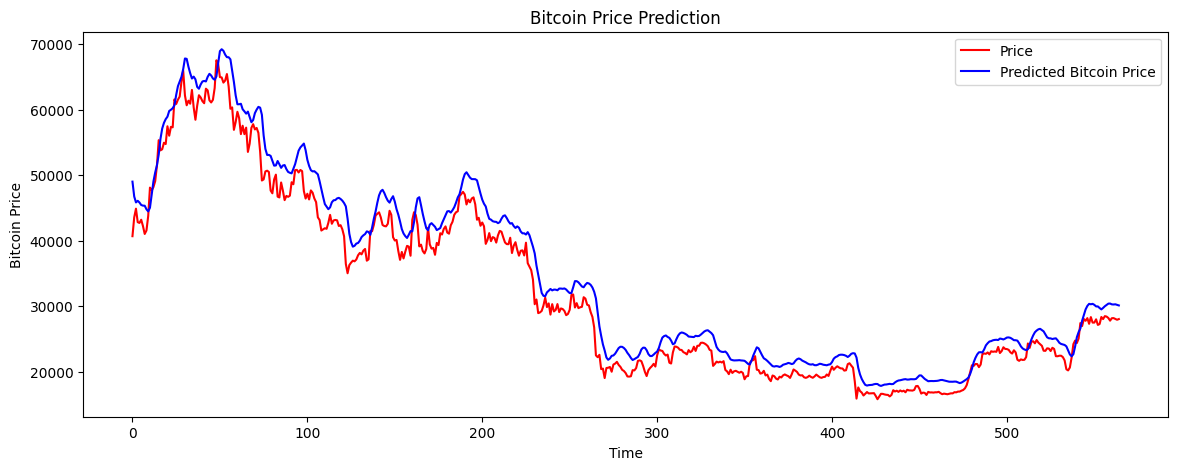

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

callback = LearningRateScheduler(scheduler)

# Read dataset
df = pd.read_csv('bitcoin-prices.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Here, 0 refers to the 'Price' column in the DataFrame

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=194, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2589961418221739))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00023202631462399754), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=39, validation_split=0.2, callbacks=[callback])

# Test data set
test_data = scaler.transform(test)

# Create the x_test and y_test data sets
X_test = []
test = test.iloc[60:]
y_test = test['Close'].values
test.reset_index(inplace=True)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

# Convert x_test to a numpy array 
X_test = np.array(X_test)

# Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # reshape X_test according to your X_train

# Check the model's prediction
predictions = model.predict(X_test)

# Assuming 'Price' is the first column in your df DataFrame
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)

# Calculate mean squared error
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error:', mean_squared_error(y_test, predictions))

predictions = predictions.flatten()  # this will convert it into (num_samples, )
# Calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, predictions))

# Import the necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('Test Mean Absolute Error:', mae)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('Test R-squared:', r2)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Test Adjusted R-squared:', adjusted_r2)

# Calculate Mean Squared Logarithmic Error (MSLE)
# Ensure all values are positive before using MSLE
if np.all(predictions > 0) and np.all(y_test > 0):
    msle = mean_squared_log_error(y_test, predictions)
    print('Test Mean Squared Logarithmic Error:', msle)
else:
    print('Can\'t calculate Mean Squared Logarithmic Error: some predictions or true values are negative or zero')


    
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

## 6. Try these hyperparamaters using bitcoin-ta.csv dataset

2500 625
Epoch 1/30
51/51 [==============================] - 9s 108ms/step - loss: 0.0599 - val_loss: 0.0386 - lr: 2.3203e-04
Epoch 2/30
51/51 [==============================] - 5s 93ms/step - loss: 0.0214 - val_loss: 0.0147 - lr: 2.3203e-04
Epoch 3/30
51/51 [==============================] - 5s 89ms/step - loss: 0.0125 - val_loss: 0.0112 - lr: 2.3203e-04
Epoch 4/30
51/51 [==============================] - 5s 90ms/step - loss: 0.0085 - val_loss: 0.0292 - lr: 2.3203e-04
Epoch 5/30
51/51 [==============================] - 5s 90ms/step - loss: 0.0066 - val_loss: 0.0115 - lr: 2.3203e-04
Epoch 6/30
51/51 [==============================] - 5s 91ms/step - loss: 0.0057 - val_loss: 0.0178 - lr: 2.3203e-04
Epoch 7/30
51/51 [==============================] - 5s 90ms/step - loss: 0.0037 - val_loss: 0.0135 - lr: 2.3203e-04
Epoch 8/30
51/51 [==============================] - 5s 92ms/step - loss: 0.0031 - val_loss: 0.0135 - lr: 2.3203e-04
Epoch 9/30
51/51 [==============================] - 5s 90ms/st

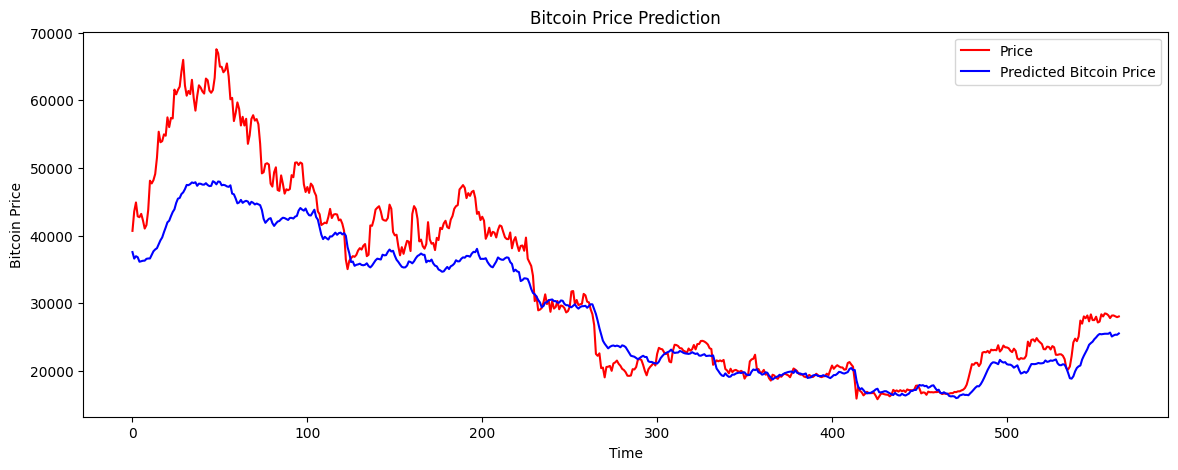

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

callback = LearningRateScheduler(scheduler)

# Read dataset
df = pd.read_csv('bitcoin-ta.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Here, 0 refers to the 'Price' column in the DataFrame

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=194, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2589961418221739))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00023202631462399754), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=39, validation_split=0.2, callbacks=[callback])

# Test data set
test_data = scaler.transform(test)

# Create the x_test and y_test data sets
X_test = []
test = test.iloc[60:]
y_test = test['Close'].values
test.reset_index(inplace=True)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

# Convert x_test to a numpy array 
X_test = np.array(X_test)

# Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # reshape X_test according to your X_train

# Check the model's prediction
predictions = model.predict(X_test)

# Assuming 'Price' is the first column in your df DataFrame
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)

# Calculate mean squared error
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error:', mean_squared_error(y_test, predictions))

predictions = predictions.flatten()  # this will convert it into (num_samples, )
# Calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, predictions))

# Import the necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('Test Mean Absolute Error:', mae)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('Test R-squared:', r2)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Test Adjusted R-squared:', adjusted_r2)

# Calculate Mean Squared Logarithmic Error (MSLE)
# Ensure all values are positive before using MSLE
if np.all(predictions > 0) and np.all(y_test > 0):
    msle = mean_squared_log_error(y_test, predictions)
    print('Test Mean Squared Logarithmic Error:', msle)
else:
    print('Can\'t calculate Mean Squared Logarithmic Error: some predictions or true values are negative or zero')


    
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

## 6. Try these hyperparamaters using bitcoin-ta-2015.csv dataset

2416 604
Epoch 1/30
49/49 [==============================] - 8s 100ms/step - loss: 0.0480 - val_loss: 0.0373 - lr: 2.3203e-04
Epoch 2/30
49/49 [==============================] - 4s 87ms/step - loss: 0.0202 - val_loss: 0.0208 - lr: 2.3203e-04
Epoch 3/30
49/49 [==============================] - 4s 87ms/step - loss: 0.0122 - val_loss: 0.0309 - lr: 2.3203e-04
Epoch 4/30
49/49 [==============================] - 4s 88ms/step - loss: 0.0073 - val_loss: 0.0194 - lr: 2.3203e-04
Epoch 5/30
49/49 [==============================] - 4s 88ms/step - loss: 0.0057 - val_loss: 0.0168 - lr: 2.3203e-04
Epoch 6/30
49/49 [==============================] - 4s 88ms/step - loss: 0.0044 - val_loss: 0.0265 - lr: 2.3203e-04
Epoch 7/30
49/49 [==============================] - 4s 88ms/step - loss: 0.0030 - val_loss: 0.0234 - lr: 2.3203e-04
Epoch 8/30
49/49 [==============================] - 4s 87ms/step - loss: 0.0025 - val_loss: 0.0194 - lr: 2.3203e-04
Epoch 9/30
49/49 [==============================] - 4s 88ms/st

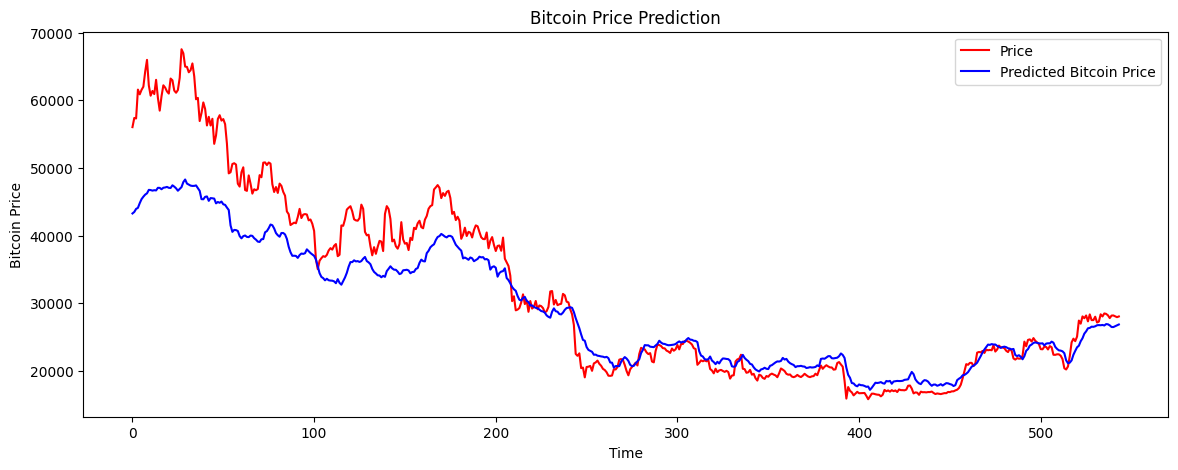

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

callback = LearningRateScheduler(scheduler)

# Read dataset
df = pd.read_csv('bitcoin-ta-2015.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Here, 0 refers to the 'Price' column in the DataFrame

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=194, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2589961418221739))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00023202631462399754), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=39, validation_split=0.2, callbacks=[callback])

# Test data set
test_data = scaler.transform(test)

# Create the x_test and y_test data sets
X_test = []
test = test.iloc[60:]
y_test = test['Close'].values
test.reset_index(inplace=True)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

# Convert x_test to a numpy array 
X_test = np.array(X_test)

# Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # reshape X_test according to your X_train

# Check the model's prediction
predictions = model.predict(X_test)

# Assuming 'Price' is the first column in your df DataFrame
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)

# Calculate mean squared error
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error:', mean_squared_error(y_test, predictions))

predictions = predictions.flatten()  # this will convert it into (num_samples, )
# Calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, predictions))

# Import the necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('Test Mean Absolute Error:', mae)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('Test R-squared:', r2)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Test Adjusted R-squared:', adjusted_r2)

# Calculate Mean Squared Logarithmic Error (MSLE)
# Ensure all values are positive before using MSLE
if np.all(predictions > 0) and np.all(y_test > 0):
    msle = mean_squared_log_error(y_test, predictions)
    print('Test Mean Squared Logarithmic Error:', msle)
else:
    print('Can\'t calculate Mean Squared Logarithmic Error: some predictions or true values are negative or zero')


    
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

In [ ]:
## 7. Try these hyperparamaters using bitcoin-data-edited.csv dataset

3024 757
Epoch 1/30
61/61 [==============================] - 12s 149ms/step - loss: 0.0050 - val_loss: 0.0232 - lr: 2.3203e-04
Epoch 2/30
61/61 [==============================] - 9s 146ms/step - loss: 0.0021 - val_loss: 0.0176 - lr: 2.3203e-04
Epoch 3/30
61/61 [==============================] - 9s 148ms/step - loss: 0.0013 - val_loss: 0.0122 - lr: 2.3203e-04
Epoch 4/30
61/61 [==============================] - 9s 147ms/step - loss: 9.5633e-04 - val_loss: 0.0140 - lr: 2.3203e-04
Epoch 5/30
61/61 [==============================] - 9s 147ms/step - loss: 7.2178e-04 - val_loss: 0.0119 - lr: 2.3203e-04
Epoch 6/30
61/61 [==============================] - 9s 147ms/step - loss: 5.7074e-04 - val_loss: 0.0099 - lr: 2.3203e-04
Epoch 7/30
61/61 [==============================] - 9s 148ms/step - loss: 4.5819e-04 - val_loss: 0.0069 - lr: 2.3203e-04
Epoch 8/30
61/61 [==============================] - 9s 148ms/step - loss: 3.7073e-04 - val_loss: 0.0057 - lr: 2.3203e-04
Epoch 9/30
61/61 [================

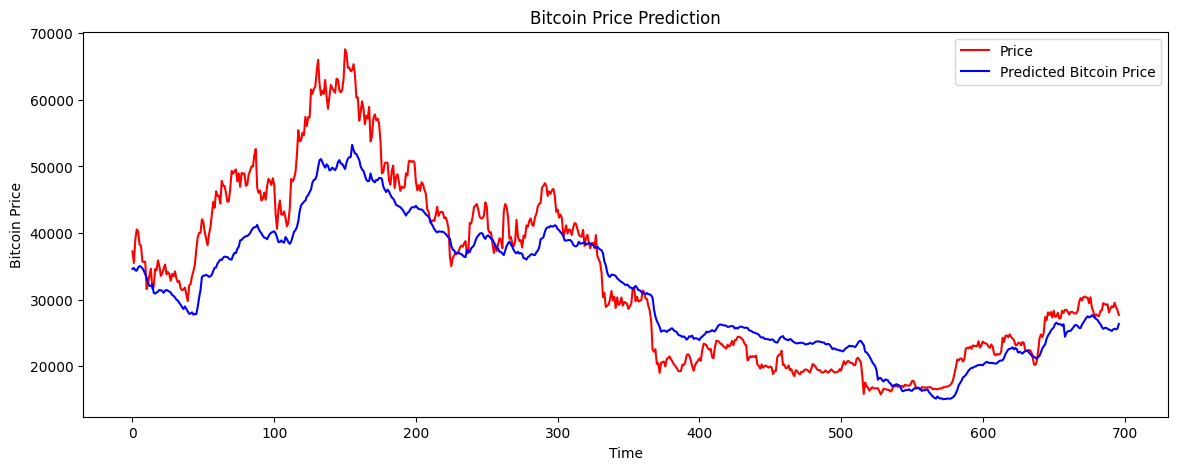

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

callback = LearningRateScheduler(scheduler)

# Read dataset
df = pd.read_csv('bitcoin-data-edited.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Here, 0 refers to the 'Price' column in the DataFrame

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=194, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2589961418221739))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00023202631462399754), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=39, validation_split=0.2, callbacks=[callback])

# Test data set
test_data = scaler.transform(test)

# Create the x_test and y_test data sets
X_test = []
test = test.iloc[60:]
y_test = test['Price'].values
test.reset_index(inplace=True)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

# Convert x_test to a numpy array 
X_test = np.array(X_test)

# Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # reshape X_test according to your X_train

# Check the model's prediction
predictions = model.predict(X_test)

# Assuming 'Price' is the first column in your df DataFrame
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)

# Calculate mean squared error
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error:', mean_squared_error(y_test, predictions))

predictions = predictions.flatten()  # this will convert it into (num_samples, )
# Calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, predictions))

# Import the necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('Test Mean Absolute Error:', mae)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('Test R-squared:', r2)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Test Adjusted R-squared:', adjusted_r2)

# Calculate Mean Squared Logarithmic Error (MSLE)
# Ensure all values are positive before using MSLE
if np.all(predictions > 0) and np.all(y_test > 0):
    msle = mean_squared_log_error(y_test, predictions)
    print('Test Mean Squared Logarithmic Error:', msle)
else:
    print('Can\'t calculate Mean Squared Logarithmic Error: some predictions or true values are negative or zero')


    
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

In [ ]:
## 6. Try these hyperparamaters using bitcoin-data-edited-2015.csv dataset

2440 610
Epoch 1/30
49/49 [==============================] - 21s 371ms/step - loss: 0.0070 - val_loss: 0.0875 - lr: 2.3203e-04
Epoch 2/30
49/49 [==============================] - 18s 358ms/step - loss: 0.0030 - val_loss: 0.0779 - lr: 2.3203e-04
Epoch 3/30
49/49 [==============================] - 18s 359ms/step - loss: 0.0019 - val_loss: 0.0561 - lr: 2.3203e-04
Epoch 4/30
49/49 [==============================] - 17s 355ms/step - loss: 0.0013 - val_loss: 0.0551 - lr: 2.3203e-04
Epoch 5/30
49/49 [==============================] - 18s 362ms/step - loss: 0.0011 - val_loss: 0.0572 - lr: 2.3203e-04
Epoch 6/30
49/49 [==============================] - 18s 369ms/step - loss: 8.5068e-04 - val_loss: 0.0466 - lr: 2.3203e-04
Epoch 7/30
49/49 [==============================] - 19s 398ms/step - loss: 6.9606e-04 - val_loss: 0.0625 - lr: 2.3203e-04
Epoch 8/30
49/49 [==============================] - 18s 365ms/step - loss: 5.6861e-04 - val_loss: 0.0482 - lr: 2.3203e-04
Epoch 9/30
49/49 [=================

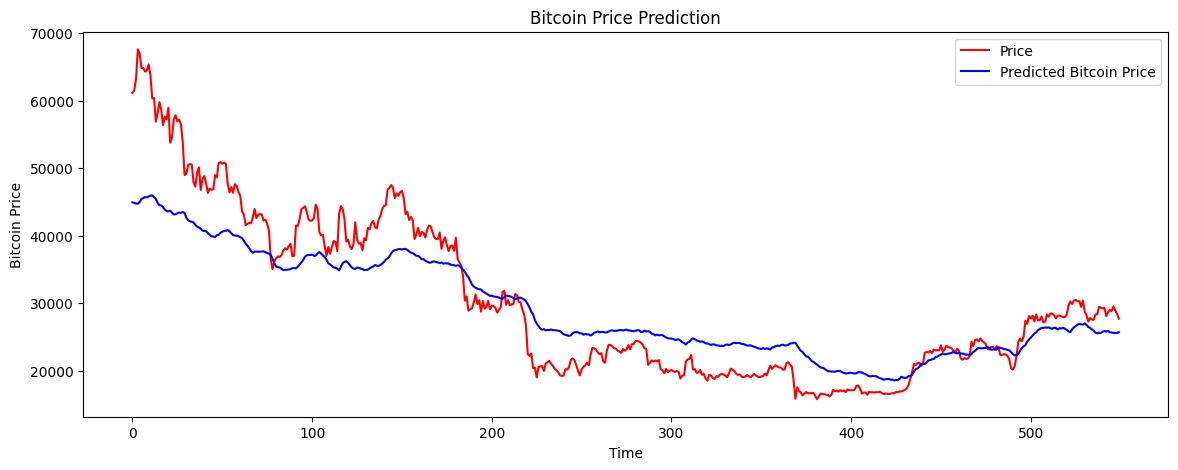

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

callback = LearningRateScheduler(scheduler)

# Read dataset
df = pd.read_csv('bitcoin-data-edited-2015.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Here, 0 refers to the 'Price' column in the DataFrame

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=194, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2589961418221739))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00023202631462399754), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=39, validation_split=0.2, callbacks=[callback])

# Test data set
test_data = scaler.transform(test)

# Create the x_test and y_test data sets
X_test = []
test = test.iloc[60:]
y_test = test['Price'].values
test.reset_index(inplace=True)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

# Convert x_test to a numpy array 
X_test = np.array(X_test)

# Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # reshape X_test according to your X_train

# Check the model's prediction
predictions = model.predict(X_test)

# Assuming 'Price' is the first column in your df DataFrame
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)

# Calculate mean squared error
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error:', mean_squared_error(y_test, predictions))

predictions = predictions.flatten()  # this will convert it into (num_samples, )
# Calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, predictions))

# Import the necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('Test Mean Absolute Error:', mae)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('Test R-squared:', r2)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Test Adjusted R-squared:', adjusted_r2)

# Calculate Mean Squared Logarithmic Error (MSLE)
# Ensure all values are positive before using MSLE
if np.all(predictions > 0) and np.all(y_test > 0):
    msle = mean_squared_log_error(y_test, predictions)
    print('Test Mean Squared Logarithmic Error:', msle)
else:
    print('Can\'t calculate Mean Squared Logarithmic Error: some predictions or true values are negative or zero')


    
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

## 7. Try these hyperparameters on bitcoin-ta-on-chain-2015.csv dataset

2416 604
Epoch 1/30
49/49 [==============================] - 22s 390ms/step - loss: 0.0427 - val_loss: 0.0168 - lr: 2.3203e-04
Epoch 2/30
49/49 [==============================] - 18s 371ms/step - loss: 0.0166 - val_loss: 0.0120 - lr: 2.3203e-04
Epoch 3/30
49/49 [==============================] - 19s 381ms/step - loss: 0.0098 - val_loss: 0.0156 - lr: 2.3203e-04
Epoch 4/30
49/49 [==============================] - 19s 380ms/step - loss: 0.0075 - val_loss: 0.0178 - lr: 2.3203e-04
Epoch 5/30
49/49 [==============================] - 19s 378ms/step - loss: 0.0056 - val_loss: 0.0158 - lr: 2.3203e-04
Epoch 6/30
49/49 [==============================] - 18s 378ms/step - loss: 0.0042 - val_loss: 0.0228 - lr: 2.3203e-04
Epoch 7/30
49/49 [==============================] - 18s 378ms/step - loss: 0.0034 - val_loss: 0.0207 - lr: 2.3203e-04
Epoch 8/30
49/49 [==============================] - 19s 379ms/step - loss: 0.0029 - val_loss: 0.0126 - lr: 2.3203e-04
Epoch 9/30
49/49 [=============================

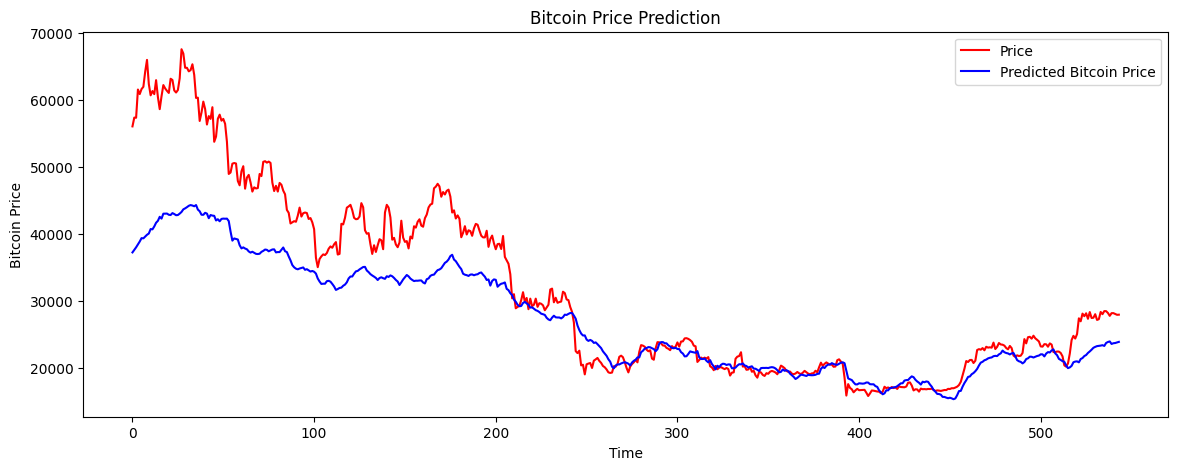

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

callback = LearningRateScheduler(scheduler)

# Read dataset
df = pd.read_csv('bitcoin-ta-on-chain-2015.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Here, 0 refers to the 'Price' column in the DataFrame

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=194, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2589961418221739))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00023202631462399754), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=39, validation_split=0.2, callbacks=[callback])

# Test data set
test_data = scaler.transform(test)

# Create the x_test and y_test data sets
X_test = []
test = test.iloc[60:]
y_test = test['Price'].values
test.reset_index(inplace=True)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

# Convert x_test to a numpy array 
X_test = np.array(X_test)

# Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # reshape X_test according to your X_train

# Check the model's prediction
predictions = model.predict(X_test)

# Assuming 'Price' is the first column in your df DataFrame
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)

# Calculate mean squared error
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error:', mean_squared_error(y_test, predictions))

predictions = predictions.flatten()  # this will convert it into (num_samples, )
# Calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, predictions))

# Import the necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('Test Mean Absolute Error:', mae)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('Test R-squared:', r2)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Test Adjusted R-squared:', adjusted_r2)

# Calculate Mean Squared Logarithmic Error (MSLE)
# Ensure all values are positive before using MSLE
if np.all(predictions > 0) and np.all(y_test > 0):
    msle = mean_squared_log_error(y_test, predictions)
    print('Test Mean Squared Logarithmic Error:', msle)
else:
    print('Can\'t calculate Mean Squared Logarithmic Error: some predictions or true values are negative or zero')


    
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

2440 610
Epoch 1/30
49/49 [==============================] - 8s 109ms/step - loss: 0.0507 - val_loss: 0.0253 - lr: 2.3203e-04
Epoch 2/30
49/49 [==============================] - 5s 92ms/step - loss: 0.0152 - val_loss: 0.0267 - lr: 2.3203e-04
Epoch 3/30
49/49 [==============================] - 4s 90ms/step - loss: 0.0105 - val_loss: 0.0375 - lr: 2.3203e-04
Epoch 4/30
49/49 [==============================] - 4s 91ms/step - loss: 0.0071 - val_loss: 0.0205 - lr: 2.3203e-04
Epoch 5/30
49/49 [==============================] - 4s 91ms/step - loss: 0.0054 - val_loss: 0.0303 - lr: 2.3203e-04
Epoch 6/30
49/49 [==============================] - 4s 92ms/step - loss: 0.0045 - val_loss: 0.0259 - lr: 2.3203e-04
Epoch 7/30
49/49 [==============================] - 4s 91ms/step - loss: 0.0035 - val_loss: 0.0329 - lr: 2.3203e-04
Epoch 8/30
49/49 [==============================] - 5s 93ms/step - loss: 0.0025 - val_loss: 0.0295 - lr: 2.3203e-04
Epoch 9/30
49/49 [==============================] - 5s 93ms/st

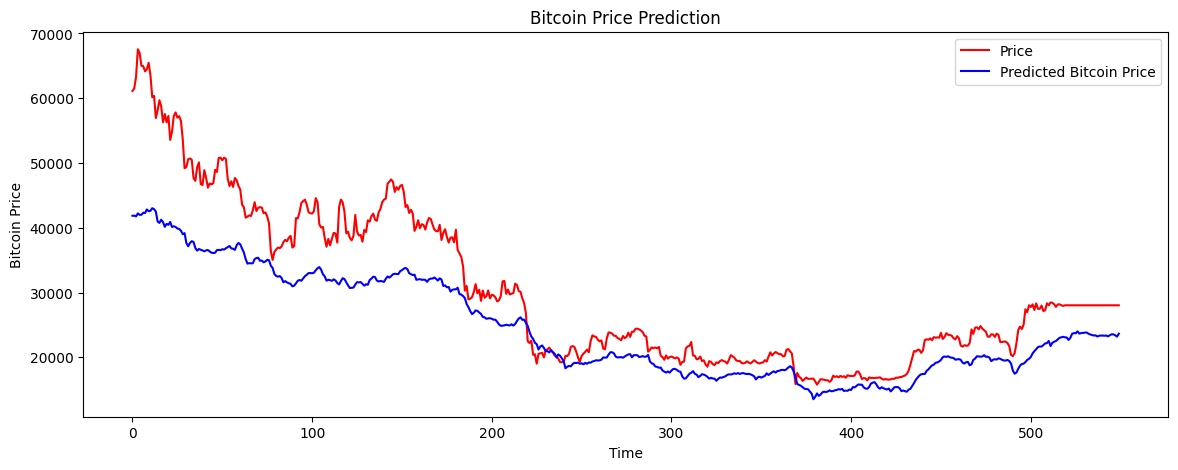

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

callback = LearningRateScheduler(scheduler)

# Read dataset
df1 = pd.read_csv('bitcoin-ta-2015.csv')

# Convert timestamp to datetime
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])






df2 = pd.read_csv('bitcoin-data-edited-2015.csv')

# Convert timestamp to datetime
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'])


df = pd.merge_asof(df2, df1, on='Timestamp')

# Set timestamp as index
df = df.set_index('Timestamp')


# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Here, 0 refers to the 'Price' column in the DataFrame

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=194, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2589961418221739))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00023202631462399754), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=39, validation_split=0.2, callbacks=[callback])

# Test data set
test_data = scaler.transform(test)

# Create the x_test and y_test data sets
X_test = []
test = test.iloc[60:]
y_test = test['Close'].values
test.reset_index(inplace=True)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

# Convert x_test to a numpy array 
X_test = np.array(X_test)

# Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # reshape X_test according to your X_train

# Check the model's prediction
predictions = model.predict(X_test)

# Assuming 'Price' is the first column in your df DataFrame
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)

# Calculate mean squared error
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error:', mean_squared_error(y_test, predictions))

predictions = predictions.flatten()  # this will convert it into (num_samples, )
# Calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, predictions))

# Import the necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('Test Mean Absolute Error:', mae)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('Test R-squared:', r2)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Test Adjusted R-squared:', adjusted_r2)

# Calculate Mean Squared Logarithmic Error (MSLE)
# Ensure all values are positive before using MSLE
if np.all(predictions > 0) and np.all(y_test > 0):
    msle = mean_squared_log_error(y_test, predictions)
    print('Test Mean Squared Logarithmic Error:', msle)
else:
    print('Can\'t calculate Mean Squared Logarithmic Error: some predictions or true values are negative or zero')


    
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()